# Prediction of Pulsar Star from Parkes Radio Telescope Data
Group 23

Pulsar is a highly magnetized neutron star or a dwarf star, that emits electromagnetic radiation out of its magnetic poles. Such stars are very dense and have high rotation, thus giving pulsing phenomenon. Pulsars are a source of ultra-high energy cosmic rays. Pulsars in a binary system are used to confirm the existence of gravitational waves. They are also much more accurate than atomic time measuring clocks here on earth. Confirming the existence of pulsar stars require manual checking of data from the telescope. With this project, we aim to automate the findings of pulsars by using predictive analytics.

Some terms used in Pulsar analysis
1. **Integrated Profile** - Pulsar produces periodic pulses due to their fast rotation and producing strong magnetic fields. You can think of it as a lighthouse with a ray of light in constant rotation. These signals are often too weak to detect and are paired with their rotation which forms an integrated pulse profile. Every Pulsar has a different Pulsar Profile and is a defining characteristic of these stars.

2. **Dispertion Measure** - Dispertion Measure or DM for short is disperstion metric of the radio waves produces by the Pulsar. These waves when reaching earth gets dispersed by the free electrons in space and gets dispersed. DM is a measure for that dispersion.

3. **SNR** - SNR stands for Signal-to-Noise Ratio and it describes how much noise is present along the signal that is of interest to us, in this case Dispersion Measure.

4. **DM-SNR** curve refers to the plot of Dispersion Measure vs Signal-to-Noise Ratio, and signifies how much noise is present in the dispersion meaurements.

5. **Kurtosis** - Kurtosis referes to the tailness (top point of the curve) of the distribution curve with comparison to the normal curve. More sharp the           curve is, more outlier that distribution holds.

6. **Skewness** - It refers to the amount by which the quantity is deviated from the symmetric bell curve. This signifies how much Pulsar signal deviates from     the normal distribution.

In [7]:
import os
import sqlite3
from sqlite3 import Error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from IPython.display import display, HTML
plt.style.use('default')
%matplotlib inline

### Utility functions

In [8]:
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

### Importing CSV file and creating Databases

#### Data Description
Each pulsar candidate is described by 8 variables and 1 target variable. Number of instances – 17,898
1. Mean of Pulsar integrated profile – pulsar signal
2. Standard deviation of integrated profile
3. Excess kurtosis of integrated profile
4. Skewness of integrated profile
5. Mean of DM-SNR curve (Dispersion measure vs signal-to-noise ratio)
6. Standard deviation of DM-SNR curve
7. Excess kurtosis of DM-SNR curve
8. Skewness of DM-SNR curve
9. Class
    * 0 - Not a Pulsar
    * 1 - A Pulsar

Creating 3 Databases
```SQL
IntegratedProfile 
  [ProfileID] Integer not null primary key
  [Mean] Real
  [StdDev] Real
  [Excess] Real
  [Skewness] Real
DmsnrCurve
  [CurveID] Integer not null Primary key
  [Mean] Real
  [StdDev] Real
  [Excess] Real
  [Skewness] Real
Target
    [TargetID] Integer not null Primary key
    [Class] Real
```

Parsing CSV file to create tuple of different data for insertion into Tables

In [9]:
def parse_csv(file):
    mean_list = []
    dmsnr_list = []
    target_list = []
    with open(file, 'r') as file:
        next(file)
        for row in file:
            contents = row.split(',')
            mean = tuple(contents[:4])
            dmsnr = tuple(contents[4:8])
            target = (contents[8].strip(),)
            mean_list.append(mean)
            dmsnr_list.append(dmsnr)
            target_list.append(target)
    return mean_list, dmsnr_list, target_list

Functions to create table and insert values into the table

In [10]:
def create_integrated_profile_db(dbfile, data):
    with create_connection(dbfile, delete_db=True) as conn:
        cur = conn.cursor()
        cur.execute("""CREATE TABLE IntegratedProfile (
            ProfileID INTEGER NOT NULL PRIMARY KEY,
            IP_Mean REAL,
            IP_StdDev REAL,
            IP_Excess REAL,
            IP_Skewness REAL
        )""")
        
        cur = conn.cursor()
        cur.executemany("INSERT INTO IntegratedProfile(IP_Mean, IP_StdDev, IP_Excess, IP_Skewness) VALUES(?,?,?,?)", data)

In [11]:
def create_dmsnr_curve_db(dbfile, data):
    with create_connection(dbfile) as conn:
        cur = conn.cursor()
        cur.execute("""CREATE TABLE DmsnrCurve (
            CurveID INTEGER NOT NULL PRIMARY KEY,
            DMSNR_Mean REAL,
            DMSNR_StdDev REAL,
            DMSNR_Excess REAL,
            DMSNR_Skewness REAL
        )""")
        
        cur = conn.cursor()
        cur.executemany("INSERT INTO DmsnrCurve(DMSNR_Mean, DMSNR_StdDev, DMSNR_Excess, DMSNR_Skewness) VALUES(?,?,?,?)", data)

In [12]:
def create_target_db(dbfile, data):
    with create_connection(dbfile) as conn:
        cur = conn.cursor()
        cur.execute("""CREATE TABLE Target (
            TargetID INTEGER NOT NULL PRIMARY KEY,
            Target REAL
        )""")
        
        cur = conn.cursor()
        cur.executemany("INSERT INTO Target(Target) VALUES(?)", data)

Collecting train and test data together for insertion

In [13]:
mean_train, dmsnr_train, target_train = parse_csv('pulsar_data_train.csv')
mean_test, dmsnr_test, _ = parse_csv('pulsar_data_test.csv')
for m,d in zip(mean_test, dmsnr_test):
    mean_train.append(m)
    dmsnr_train.append(d)

Inserting values into 3 tables

In [14]:
create_integrated_profile_db('pulsar.db', mean_train)
create_dmsnr_curve_db('pulsar.db', dmsnr_train)
create_target_db('pulsar.db', target_train)

Next step is to read data from database using Pandas and do exploratory data analysis and visualization

In [15]:
conn = create_connection('pulsar.db')
df = pd.read_sql_query("""SELECT I.IP_Mean, I.IP_StdDev, I.IP_Excess, I.IP_Skewness, D.DMSNR_Mean, D.DMSNR_StdDev, D.DMSNR_Excess, D.DMSNR_Skewness, T.Target from Target T
                           LEFT JOIN DmsnrCurve D
                           ON T.TargetID = D.CurveID
                           LEFT JOIN IntegratedProfile I
                           ON T.TargetID = I.ProfileID""", conn)
display(df.head(5))

,IP_Mean,IP_StdDev,IP_Excess,IP_Skewness,DMSNR_Mean,DMSNR_StdDev,DMSNR_Excess,DMSNR_Skewness,Target
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


## Exploratory Data Analysis

Remove blank value from Dataframe and convert Dataframe columns to appropriate datatype

In [16]:
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.apply(pd.to_numeric, errors='coerce')
df['Target'] = df['Target'].astype(int)
display(df.head())

,IP_Mean,IP_StdDev,IP_Excess,IP_Skewness,DMSNR_Mean,DMSNR_StdDev,DMSNR_Excess,DMSNR_Skewness,Target
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0
7,109.406250,55.912521,0.565106,0.056247,2.797659,19.496527,9.443282,97.374578,0


Summary of the dataset

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9273 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   IP_Mean         9273 non-null   float64
 1   IP_StdDev       9273 non-null   float64
 2   IP_Excess       9273 non-null   float64
 3   IP_Skewness     9273 non-null   float64
 4   DMSNR_Mean      9273 non-null   float64
 5   DMSNR_StdDev    9273 non-null   float64
 6   DMSNR_Excess    9273 non-null   float64
 7   DMSNR_Skewness  9273 non-null   float64
 8   Target          9273 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 724.5 KB


Converting classes into ineteger and calculating target values ratios
```
0 -> Star is not a Pulsar
1 -> Star is a Pulsar
```

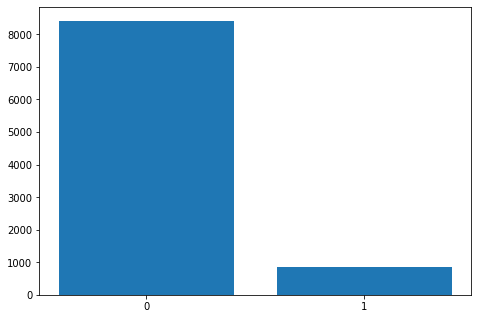

In [18]:
classes = df['Target'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['0', '1']
ax.bar(langs,classes)
plt.show()

Scatterplots to visualize relation between `IP_Mean` and `DMSNR_Mean`

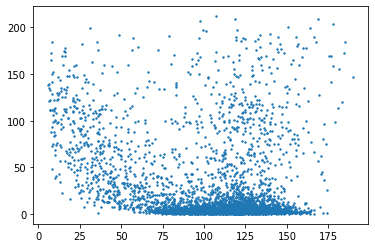

In [19]:
plt.scatter(df['IP_Mean'], df['DMSNR_Mean'], s=2)

Scatterplot to visualize relation between `IP_StdDev` and `DMSNR_StdDev`

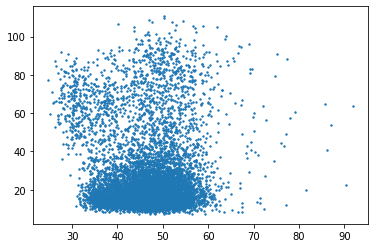

In [20]:
plt.scatter(df['IP_StdDev'], df['DMSNR_StdDev'], s=2)

Calculating correlation between different variables, to see what variables are highly related to other.

Heatmap of the correlation matrix to visualize the multicollinearity between varibales

In [21]:
df.corr()

,IP_Mean,IP_StdDev,IP_Excess,IP_Skewness,DMSNR_Mean,DMSNR_StdDev,DMSNR_Excess,DMSNR_Skewness,Target
IP_Mean,1.000000,0.554197,-0.872497,-0.734920,-0.299984,-0.307431,0.236010,0.146103,-0.675819
IP_StdDev,0.554197,1.000000,-0.528370,-0.542560,-0.011061,-0.059486,0.036907,0.030959,-0.368223
IP_Excess,-0.872497,-0.528370,1.000000,0.944715,0.421126,0.436362,-0.344571,-0.216748,0.790866
IP_Skewness,-0.734920,-0.542560,0.944715,1.000000,0.415570,0.415902,-0.328328,-0.204109,0.704743
DMSNR_Mean,-0.299984,-0.011061,0.421126,0.415570,1.000000,0.796449,-0.614526,-0.353186,0.407043
DMSNR_StdDev,-0.307431,-0.059486,0.436362,0.415902,0.796449,1.000000,-0.807013,-0.573260,0.493163
DMSNR_Excess,0.236010,0.036907,-0.344571,-0.328328,-0.614526,-0.807013,1.000000,0.924326,-0.390352
DMSNR_Skewness,0.146103,0.030959,-0.216748,-0.204109,-0.353186,-0.573260,0.924326,1.000000,-0.258428
Target,-0.675819,-0.368223,0.790866,0.704743,0.407043,0.493163,-0.390352,-0.258428,1.000000


Heatmap of the correlation matrix to visualize the multicollinearity between varibales

<AxesSubplot:>

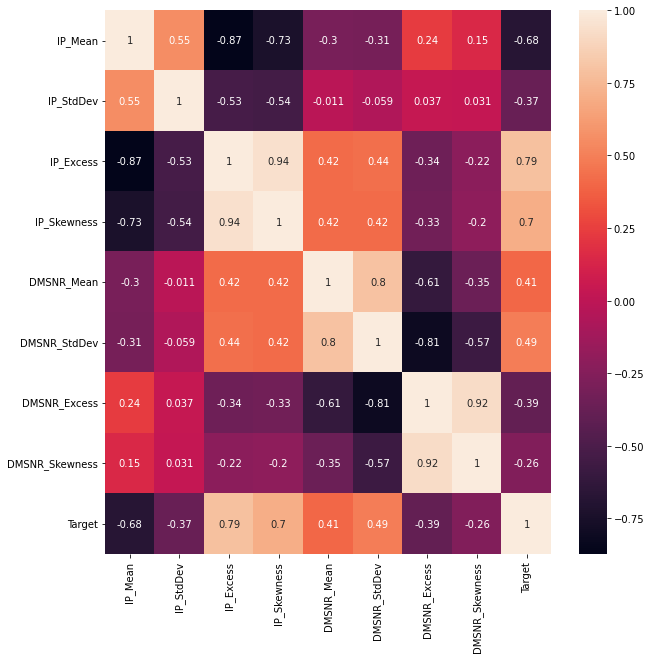

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr() ,annot = True)

**High positive correlation between:**
* IP_Excess and IP_Skewness

**High negative correlation between:**
* IP_Skewness and IP_Mean
* IP_Excess and IP_Mean

**Correlations between independent and dependent variable:**
* IP_Excess and IP_Skewness have a high positive correlation with Target
* IP_Mean has high negative correlation with Target.

Visualizing the range of IP_Mean and DMSNR_Mean values, where maximum number of pulsar stars are found, to get the sense of how the target class is dispersed in the dataset.

Text(0, 0.5, 'Number of pulsar stars')

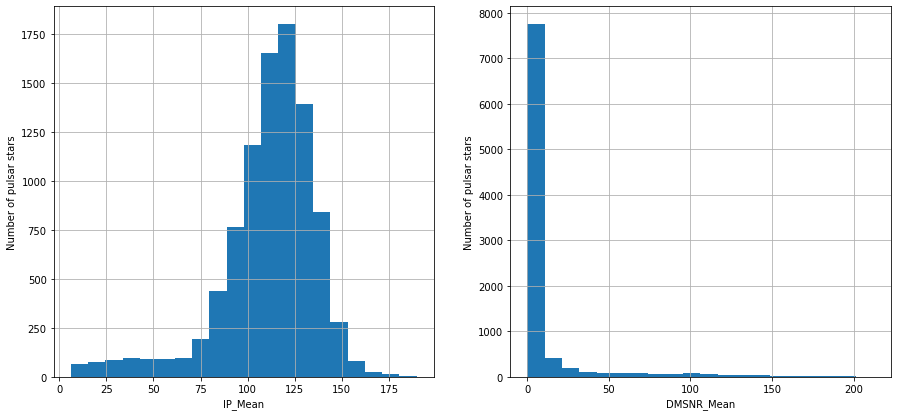

In [23]:
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
fig = df['IP_Mean'].hist(bins=20)
fig.set_xlabel('IP_Mean')
fig.set_ylabel('Number of pulsar stars')

plt.subplot(2, 2, 2)
fig = df['DMSNR_Mean'].hist(bins=20)
fig.set_xlabel('DMSNR_Mean')
fig.set_ylabel('Number of pulsar stars')

## Preprocessing

### Normalising the values

We are normalising the values of the dataframe so as to improve performance of ML algorihtm. This means that algorithm gives equal weightage to all the input variables.

In [46]:
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
rescaled_data = scaler.fit_transform(df.drop(columns='Target'))
standard_df= pd.DataFrame(rescaled_data,index=df.index,columns=df.drop(columns='Target').columns)
standard_df['Target'] = df['Target']
df = standard_df

In [47]:
df.head()

,IP_Mean,IP_StdDev,IP_Excess,IP_Skewness,DMSNR_Mean,DMSNR_StdDev,DMSNR_Excess,DMSNR_Skewness,Target
0,0.626373,0.352060,0.215498,0.025449,0.013959,0.106795,0.271319,0.056276,0
1,0.385630,0.170109,0.249901,0.074121,0.010326,0.098774,0.324168,0.087764,0
2,0.677748,0.424507,0.190815,0.021385,0.011949,0.145172,0.299790,0.063713,0
4,0.428322,0.169245,0.261333,0.072482,0.012170,0.128279,0.297010,0.065607,0
7,0.562356,0.464530,0.234832,0.026442,0.012206,0.117419,0.324938,0.083280,0


We will now split the dataset into training and test set using sklearn's `train_test_split` function, with splitting ratio of 70/30 for training and testing respectively

In [48]:
x = df.drop('Target',axis=1)
y = df['Target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30)

In [49]:
x

,IP_Mean,IP_StdDev,IP_Excess,IP_Skewness,DMSNR_Mean,DMSNR_StdDev,DMSNR_Excess,DMSNR_Skewness
0,0.626373,0.352060,0.215498,0.025449,0.013959,0.106795,0.271319,0.056276
1,0.385630,0.170109,0.249901,0.074121,0.010326,0.098774,0.324168,0.087764
2,0.677748,0.424507,0.190815,0.021385,0.011949,0.145172,0.299790,0.063713
4,0.428322,0.169245,0.261333,0.072482,0.012170,0.128279,0.297010,0.065607
7,0.562356,0.464530,0.234832,0.026442,0.012206,0.117419,0.324938,0.083280
...,...,...,...,...,...,...,...,...
12522,0.646378,0.385084,0.201027,0.021532,0.010058,0.063711,0.319099,0.099989
12523,0.643569,0.423754,0.175947,0.017682,0.032934,0.212428,0.192815,0.019868
12525,0.598451,0.275101,0.244860,0.031834,0.002701,0.041228,0.529689,0.263359
12526,0.705414,0.375343,0.168042,0.022393,0.017221,0.136834,0.269934,0.053908


In [50]:
y

0        0
1        0
2        0
4        0
7        0
        ..
12522    0
12523    0
12525    0
12526    0
12527    0
Name: Target, Length: 9273, dtype: int64

## Support Vector Machines

Data for pulsar analysis is non-linear and SVM is the model that is suitbale for non-linear data modeling, while being easier to interpret. Therefore, we decided to use Support Vector Machine as our model for classifying stars as pulsar or not. 

### Model Training

We are now instantiating the SVC class which create an SVC object and expose fit method to train the Support Vector Machine model with linear kernel and with feature set and its corresponding target labels

In [51]:
model = svm.SVC(kernel='linear').fit(x_train, y_train)

### Model Evaluation 

We are calculating training accuracy of the SVM model along with other metrics such as precision, recall and F1-score. We will compare this metrics with the metrics obtained via testing set and compare the model's genralizability of the overall problem that we are trying to solve.

In [52]:
y_pred = model.predict(x_train)
print( "SVM best accuracy : " + str(np.round(metrics.accuracy_score(y_train, y_pred),3)))

SVM best accuracy : 0.976


In [53]:
y_pred = model.predict(x_test)
print( "SVM best accuracy : " + str(np.round(metrics.accuracy_score(y_test, y_pred),3)))

SVM best accuracy : 0.972


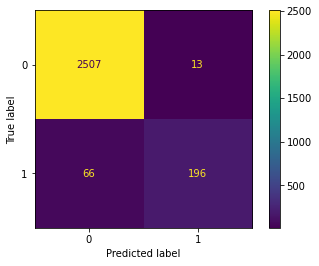

In [54]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [41]:
print('Classification Report on the test data -\n\n',metrics.classification_report(y_test, model.predict(x_test)))

Classification Report on the test data -

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      2508
           1       0.93      0.81      0.87       274

    accuracy                           0.98      2782
   macro avg       0.95      0.90      0.93      2782
weighted avg       0.97      0.98      0.97      2782



Due to high imbalances data set, accuracy is not enough and can often be misleading. Therefore, we will look at precision and recall to judge the performance of our model.

We received high precision score for both the classes `0` and `1`. This means that our model is able to correctly identify datapoints to its correct class. This is important as we have high class imbalance in our dataset and model is performing well insspite of that.

Recall is also high for our model, for class `0`, which signifies out of all the true `0` class datapoints, how many did the model got correct, which is not surprising, since model had abundant data to train from. Where as it falls behind for class `1`, due to significantly less datapoints, but nevertheless is still high, if you look at the support for each class.

## Conclusion

Even with high class imbalance in the dataset, SVM model performed better than average on classifying a star as Pulsar or no Pulsar. We have received high scores for precision snd recall for both the classes, signaling that model in able to distinguish both the classes well, which supports the statement that SVM is a suitable model for situations, where dataset has class imbalance.